<a href="https://colab.research.google.com/github/joaochenriques/MCTE_2020_2021/blob/main/BarrageExamples/Barrage_ebb_FSM2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as mpl
import numpy as np

In [2]:
%config InlineBackend.figure_formats = ['svg']
mpl.rcParams["figure.figsize"] = (12, 3)
#np.warnings.filterwarnings('error', category=np.VisibleDeprecationWarning) 

## Turbine hill map and turbine operating curve

Turbine dimensionless numbers

* Rotational speed $$n_{11}=\dfrac{\Omega D}{\sqrt{gh}}$$

* Flow rate $$Q_{11} = \dfrac{Q}{D^2\sqrt{gh}}$$

* Efficiency $$\eta_\mathrm{turb} = \dfrac{P_\mathrm{turb}}{P_\mathrm{hydro}}$$

  where $P_\mathrm{hydro} = \rho g h Q$

<img src="https://raw.githubusercontent.com/joaochenriques/MCTE_2020_2021/main/Barrages_Turbine_Generator_Maps/TurbineHill_Plot.svg" width="500px" style="display:inline">

The in sluicing mode the "turbine" is modelled as 

$$Q_\mathrm{turb}^\mathrm{sluice} = C_\mathrm{d} A_\mathrm{turb} \sqrt{ 2 g h }$$

where $A_\mathrm{turb}$ is the area corresponding to the turbine rotor diameter

In [3]:
class TurbineModel:

  def __init__( self, D_turb, Omega ):
    # red line of the map
    self.poly_CQ1 = np.poly1d( np.array([0.16928201, 0.08989368]) )
    # green line of the map
    self.poly_CQ2 = np.poly1d( np.array([-3.63920467e-04,  9.37677378e-03, 
                                         -9.25873626e-02,  1.75687197e+00]) )

    # red line of the map
    self.poly_CE1 = np.poly1d( np.array([-0.02076456, 0.20238444, 0.48984553]) )
    # green line of the map
    self.poly_CE2 = np.poly1d( np.array([-2.75685709e-04,  2.04822984e-03,  
                                         6.86081825e-04,  7.93083108e-01]) )

    # n11 interpolation domain
    self.n11_min = 4.38
    self.n11_max = 17.17

    # other data
    self.ga = 9.8         # gravity aceleration
    self.ρw = 1025.0      # water density
    self.CD_sluice = 1.0  # discharge coefficient in sluice mode

    self.Omega = Omega    # we are assuming constant rotational speed model
    self.D_turb = D_turb  # turbine rotor diameter
    self.A_turb = np.pi*(D_turb/2.0)**2 

    # constants used in for computing n11 and QT
    self.CT0 = Omega * D_turb / np.sqrt( self.ga )
    self.CT1 = D_turb**2 * np.sqrt( self.ga )

  def n11_range( self ):
    return self.n11_min, self.n11_max

  # dimensionless velocity
  def n11( self, h ):
    # avoid division by zero on h=0.0
    return self.CT0 / np.sqrt( max( h, 1E-3 ) ) 

  # dimensionless flow rate
  def Q11( self, n11 ):
    assert( n11 >= self.n11_min )
    assert( n11 <= self.n11_max )
    if n11 < 7.92193025936073:
      return self.poly_CQ1( n11 ) 
    else:
      return self.poly_CQ2( n11 )

  # efficiency
  def eta( self, n11 ):
    assert( n11 >= self.n11_min )
    assert( n11 <= self.n11_max )
    if n11 < 7.92193025936073:
      return self.poly_CE1( n11 ) * 0.912
    else:
      return self.poly_CE2( n11 ) * 0.912

  # computing operational data
  def operating_point( self, h ):
    n11 = self.n11( h )
    QT = self.CT1 * self.Q11( n11 ) * np.sqrt( h )
    PH = self.ρw * self.ga * h * QT
    ηT = self.eta( n11 )
    return QT, PH, ηT  
  
  # turbine flow rate in sluice mode
  def sluicing( self, h ):
    QS = -self.CD_sluice * self.A_turb * np.sqrt( 2.0 * self.ga * max( -h, 0.0 ) )
    return QS

## Generator efficiency curve

The generator efficiency is computed as a function of the load

$$\Lambda = \dfrac{P_\mathrm{turb}}{P_\mathrm{gen}^\mathrm{rated}}$$


<img src="https://raw.githubusercontent.com/joaochenriques/MCTE_2020_2021/main/Barrages_Turbine_Generator_Maps/GeneratorEff_plot.svg" width="400px" style="display:inline">


In [4]:
class GeneratorModel:

  def __init__( self, Pgen_rated ):
    self.Pgen_rated = Pgen_rated

    # red part of the curve
    self.poly_C1 = np.poly1d( np.array([-6.71448631e+03,  2.59159775e+03, 
                                        -3.80834059e+02,  2.70423225e+01, 
                                        3.29394948e-03]) )
    # green part of the curve
    self.poly_C2 = np.poly1d( np.array([-1.16856952,  3.31172525, -3.44296217,  
                                        1.5416029 ,  0.71040716]) )
      
  # efficiency as a function of the load
  def eta( self, shaft_power ):
    load = shaft_power / self.Pgen_rated
    assert( load >= 0 and load <= 1.0 )
    if load < 0.125423729:
      return self.poly_C1( load ) 
    else:
      return self.poly_C2( load )

## Sluice gates

The sluice gates are modelled as a turbulent pressure drop

$$Q_\mathrm{sluice} = C_\mathrm{d} A \sqrt{ 2 g h }$$

typical discharge coefficients for barrage sluice gates are within the range $0.8 \le C_\mathrm{d} \le 1.2$. Here we use $C_\mathrm{d}=1.0$. 

In [5]:
class GateModel:

  def __init__( self, Area ):
    self.ga = 9.8
    self.Area = Area
    self.CD_sluice = 1.0

  # flow rate as a function of h
  def sluicing( self, h ):
    QS = -self.CD_sluice * self.Area * np.sqrt( 2.0 * self.ga * max( -h, 0.0 ) )
    return QS

## Basin modelling

The basin is modelled as a "shoe box". The out flow is denoted as positive.

The instantaneous basin volume is computed from

$$\dfrac{\mathrm{d}V}{\mathrm{d}t}=-Q.$$

The integrating with the Euler method we get

$$V(t+\Delta t)=V(t)-\Delta t\,Q.$$

The instantaneous basin level is given by

$$h = \dfrac{V}{A_\mathrm{basin}},$$

where $A_\mathrm{basin}$ is the basin area.

<img src="https://raw.githubusercontent.com/joaochenriques/MCTE_2020_2021/main/BarrageExamples/Figures/BasinShoeBox.svg" width="300px" style="display:inline">



In [6]:
class BasinModel:

  def __init__( self, A_basin, h0 ):
    self.A_basin = A_basin
    self.V0 = A_basin * h0
    self.V = None

  # set initial condition
  def start( self ):
    self.V = self.V0
    return self.level()

  # compute volume 
  def integrate( self, delta_t, Q ):
    self.V = self.V - delta_t * Q
    return self.level()

  # water level in the base 
  def level( self ):
      return self.V / self.A_basin

## Tide modelling

The tide level is assumed to be a trignometric series

$$z(t) = \sum_i^n \zeta_i \cos\left( \omega_i t + \phi_i \right).$$

Since the available head to the turbine is a function of the tide level,
the minimum head required to start the turbine is also implemented in this class.  

In [7]:
class TideModel:
 
  #  ζ_tide, period and φ_tide are vector to allow simulate 
  # multi-component tides
  def __init__( self, ζ_tide, τ_tide, φ_tide ):
      self.ζ_tide = ζ_tide # tide amplitude
      self.τ_tide = τ_tide # tide period
      self.ω_tide = 2.0 * np.pi / τ_tide 
      self.φ_tide = φ_tide
    
  # tide level as a function t
  def level( self, t ):    
      return self.ζ_tide * np.cos( self.ω_tide * t + self.φ_tide )

  # minimum head to start the turbine as a function t
  def minimum_turbine_head( self, t ):
    return 8.0

## Power plant operation model 

The power plant modelling and control is based in the following finite state machine
 
<img src="https://raw.githubusercontent.com/joaochenriques/MCTE_2020_2021/main/BarrageExamples/Figures/EbbOperation.svg" width="700px" style="display:inline">

In [8]:
class EbbOperations_FSM:

  #===================================================
  def __init__( self ):
    self.transitions = [ self.__transition_0_1, 
                         self.__transition_1_2,
                         self.__transition_2_3,
                         self.__transition_3_4,
                         self.__transition_4_1 ]

    self.states = [ self.__run_state_hold,
                    self.__run_state_generate,
                    self.__run_state_hold,
                    self.__run_state_fill,
                    self.__run_state_hold ]         

    self.cur_state = 0

  #== TRANSITIONS ====================================
  def __transition_0_1( self, h, h_min, n11, n11_max ):
    if ( h - h_min ) > 0.0:
      self.cur_state = 1

  def __transition_1_2( self, h, h_min, n11, n11_max ):
    if ( n11 - n11_max ) >  0.0:
      self.cur_state = 2

  def __transition_2_3( self, h, h_min, n11, n11_max ):
    if h < 0.0:
      self.cur_state = 3

  def __transition_3_4( self, h, h_min, n11, n11_max ):
    if h > 0.0:
      self.cur_state = 4

  def __transition_4_1( self, h, h_min, n11, n11_max ):
    if ( h - h_min ) > 0.0:
      self.cur_state = 1

  #== STATES =========================================
  def __run_state_hold( self, h, _ ):
    QS = QT = PH = ηT = ηG = 0
    return QS, QT, PH, ηT, ηG

  def __run_state_generate( self, h, models ):
    QS = 0.0
    QT, PH, ηT = models.turbine.operating_point( h )
    ηG = models.generator.eta( ηT * PH )
    return QS, QT, PH, ηT, ηG

  def __run_state_fill( self, h, models ):
    QS = models.gate.sluicing( h )
    QT = models.turbine.sluicing( h )
    PH = ηT = ηG = 0.0
    return QS, QT, PH, ηT, ηG

  #== RUN FSM ========================================
  def transition( self, h, h_min, n11, n11_max ):
    self.transitions[ self.cur_state ]( h, h_min, n11, n11_max )
    return self.cur_state

  def run_state( self, h, models ):
    return self.states[ self.cur_state ]( h, models )

  #== RUN POWER PLANT MODEL ==========================
  def run_model( self, delta_t, t_final, models ):


    #==============================================
    t = delta_t                    # time step
    n = int( t_final / delta_t )   # number of time steps

    #==============================================
    # store computed time series
    time_vec = np.zeros( n )  # time 
    tide_vec = np.zeros( n )  # tide level

    s_vec  = np.zeros( n )    # control stages
    h_vec  = np.zeros( n )    # water height level
    z_vec  = np.zeros( n )    # basin level
    QS_vec = np.zeros( n )    # sluice gates + turbine flow rate on sluicing
    QT_vec = np.zeros( n )    # turbine flow rate
    PH_vec = np.zeros( n )    # hydraulic power
    ηT_vec = np.zeros( n )    # turbine efficiency
    ηG_vec = np.zeros( n )    # generator efficiency

    #==============================================
    n11_min, n11_max = models.turbine.n11_range()
    z = models.basin.start()
    ζ = models.tide.level( 0.0 )
    h = z - ζ
    
    #==============================================
    tide_vec[0] = ζ
    h_vec[0] = h
    z_vec[0] = z

    #==============================================
    for i in range( 1, n ):

      t = i * delta_t

      # select state
      h_min = models.tide.minimum_turbine_head( t )
      n11 = models.turbine.n11( h )
      state = self.transition( h, h_min, n11, n11_max )

      # compute state
      QS, QT, PH, ηT, ηG = self.run_state( h, models )

      # new basin condition as a function of flow rate (turbines+sluice gates) 
      z = models.basin.integrate( delta_t, models.n_turbs*QT + models.n_gates*QS )
      ζ = models.tide.level( t )
      h = z - ζ

      #==========================================
      # store data for post-processing
      time_vec[i] = t
      tide_vec[i] = ζ

      s_vec[i]  = state
      h_vec[i]  = h
      z_vec[i]  = z
      QS_vec[i] = QS
      QT_vec[i] = QT
      PH_vec[i] = PH
      ηT_vec[i] = ηT
      ηG_vec[i] = ηG
  
    return time_vec, tide_vec, s_vec, h_vec, z_vec, QS_vec, \
            QT_vec, PH_vec, ηT_vec, ηG_vec

In [9]:
class Models:

    def __init__( self, n_turbs, Dturb, Pgen_rated,
                        n_gates, Agates ):

      self.n_turbs = n_turbs # number of turbines
      self.n_gates = n_gates  # number of sluice gates

      self.turbine = TurbineModel( D_turb = Dturb, Omega = 93.75*np.pi/30.0 )
      self.generator = GeneratorModel( Pgen_rated = Pgen_rated )
      
      self.gate = GateModel( Area = Agates )

      # The tide amplitude, ζ_tide, tide period, τ_tide, and tide phase, φ_tide, are
      # vectors. Add vector entries to model more than one tide component   
      self.tide_period = 12.0*3600.0 + 25.2*60.0

      self.tide = TideModel( ζ_tide = np.array( [ 6.75 ] ), 
                        τ_tide = np.array( [ self.tide_period ] ),
                        φ_tide = np.array( [ 0.0 ] ) )
      
      # h0 is the initial basin level
      self.basin = BasinModel( A_basin = 22E6, h0 = 8 )


simulator = EbbOperations_FSM()

models = Models( n_turbs = 24, Dturb = 5.35, 
                    Pgen_rated = 30E6,
                    n_gates = 6, Agates = 10.0*15.0 )

tide_period = models.tide.τ_tide[0]
simul_time = 5*tide_period

time_vec, tide_vec, s_vec, h_vec, z_vec, QS_vec, QT_vec, PH_vec, \
  ηT_vec, ηG_vec = simulator.run_model( 100.0, simul_time, models )

hours_vec = time_vec / 3600.0
period_hours = tide_period / 3600.0

PG_vec = PH_vec * ηT_vec * ηG_vec

PG_max = np.max( PG_vec )
PG_avg = np.mean( PG_vec )
C_fac = PG_avg / models.generator.Pgen_rated
C_fac

print( "Plant Power = %.2f MW" % (PG_avg*models.n_turbs/1E6) ) 
print( "Plant Max P(t) = %.2f MW" % (PG_max/1E6) ) 
print( "Cap factor = %.2f" % C_fac )

Plant Power = 198.28 MW
Plant Max P(t) = 28.30 MW
Cap factor = 0.28


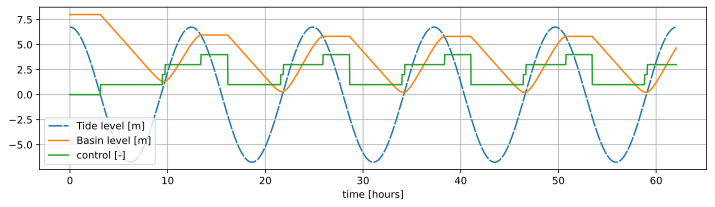

In [10]:
mpl.plot( hours_vec, tide_vec, label='Tide level [m]', dashes=(9,1) )
mpl.plot( hours_vec, z_vec, label='Basin level [m]' )
mpl.plot( hours_vec, s_vec, label='control [-]' )
#mpl.xlim( 3*period_hours, 5*period_hours )
mpl.xlabel( 'time [hours]' )
mpl.legend(loc='lower left')
mpl.grid();

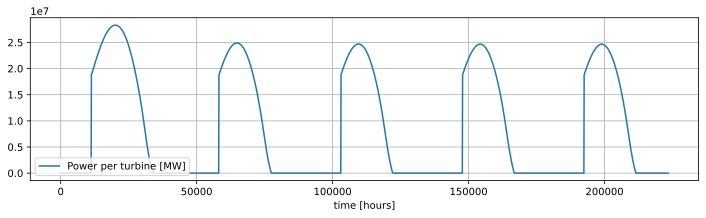

In [11]:
mpl.plot( time_vec, PG_vec, label='Power per turbine [MW]'  )
#mpl.xlim( 3*period_hours, 5*period_hours )
mpl.xlabel( 'time [hours]' )
mpl.legend(loc='lower left')
mpl.grid();

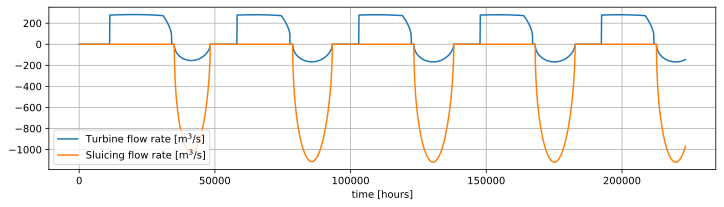

In [12]:
mpl.plot( time_vec, QT_vec, label='Turbine flow rate [m$^3$/s]' )
mpl.plot( time_vec, QS_vec, label='Sluicing flow rate [m$^3$/s]' )
#mpl.xlim( 3*period_hours, 5*period_hours )
mpl.xlabel( 'time [hours]' )
mpl.legend(loc='lower left')
mpl.grid();

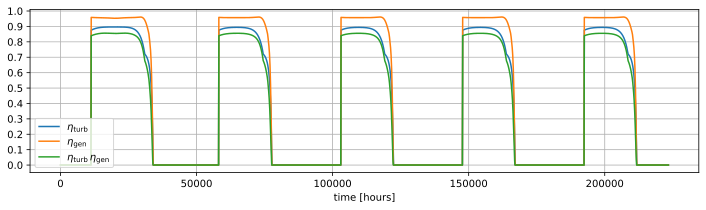

In [13]:
mpl.plot( time_vec, ηT_vec, label='$\eta_\mathrm{turb}$' )
mpl.plot( time_vec, ηG_vec, label='$\eta_\mathrm{gen}$' )
mpl.plot( time_vec, ηT_vec*ηG_vec, label='$\eta_\mathrm{turb}\,\eta_\mathrm{gen}$' )
#mpl.xlim( 3*period_hours, 5*period_hours )
mpl.xlabel( 'time [hours]' )
mpl.legend(loc='lower left')
mpl.gca().set_yticks(np.arange( 0, 1.01, 0.1) )
mpl.grid();